In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
# import necessary libraries

In [7]:
# Import required libraries
os.chdir(r'C:\Users\Jeffrey\Downloads\LightTest\lightpics\cropped_lisa_1')

# Store data, labels in the list
data = []
labels = []

# Classes: 0 - Red, 1 - Green, 2 - Yellow
classes = 3
cur_path = os.getcwd()


In [8]:
# Preprocess the images
for i, color in enumerate(['red', 'green', 'yellow']):
    path = os.path.join(cur_path, 'train_1', color)
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30,30))
            image = np.array(image)
            if image.shape == (30, 30, 3):
                data.append(image)
                labels.append(i)
            else:
                print(f"Ignoring image '{a}' in directory '{color}' due to shape mismatch.")
        except Exception as e:
            print(e)

Ignoring image 'yellow_61.png' in directory 'yellow' due to shape mismatch.
Ignoring image 'yellow_62.png' in directory 'yellow' due to shape mismatch.


In [9]:
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure the directory exists before saving data
save_dir = './training/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [10]:
# Save Labels & Data for future use
np.save(os.path.join(save_dir, 'data'), data)
np.save(os.path.join(save_dir, 'target'), labels)

# Load data & Labels
data = np.load('./training/data.npy')
labels = np.load('./training/target.npy')
print(data.shape, labels.shape)

(4498, 30, 30, 3) (4498,)


In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

(3598, 30, 30, 3) (900, 30, 30, 3) (3598,) (900,)


In [12]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the height
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels using the nearest value
)

In [13]:
# Generate augmented data
augmented_data = []
augmented_labels = []

for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
    augmented_data.append(x_batch)
    augmented_labels.append(y_batch)
    break  # Exit after generating one batch

In [14]:
# Concatenate the augmented data with the original data
augmented_data = np.concatenate(augmented_data)
augmented_labels = np.concatenate(augmented_labels)

# Shuffle the augmented data and labels
augmented_data, augmented_labels = shuffle(augmented_data, augmented_labels)

In [15]:
# Define early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


In [16]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(classes, activation='softmax'))

c:\Users\Jeffrey\Downloads\LightTest\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compilation of the model with early stopping and learning rate reduction
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Fit the model with callbacks
epochs = 20
history = model.fit(
    augmented_data, augmented_labels, 
    batch_size=32, epochs=epochs, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4627 - loss: 3.1673 - val_accuracy: 0.6578 - val_loss: 0.7799
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6183 - loss: 0.7852 - val_accuracy: 0.6033 - val_loss: 0.7059
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6017 - loss: 0.7136 - val_accuracy: 0.7100 - val_loss: 0.5669
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6525 - loss: 0.6229 - val_accuracy: 0.8867 - val_loss: 0.4875
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8896 - loss: 0.4372 - val_accuracy: 0.9667 - val_loss: 0.1251
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9166 - loss: 0.2744 - val_accuracy: 0.9556 - val_loss: 0.1558
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9407 - loss: 0.2124 - val_accuracy: 0.9778 - val_loss: 0.0639
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9511 - loss: 0.1842 - val_accuracy: 0.

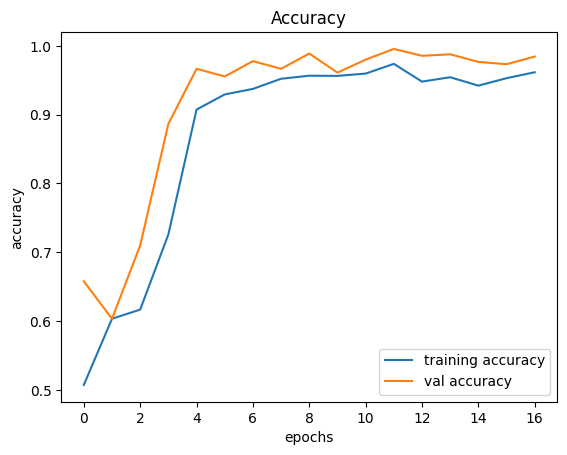

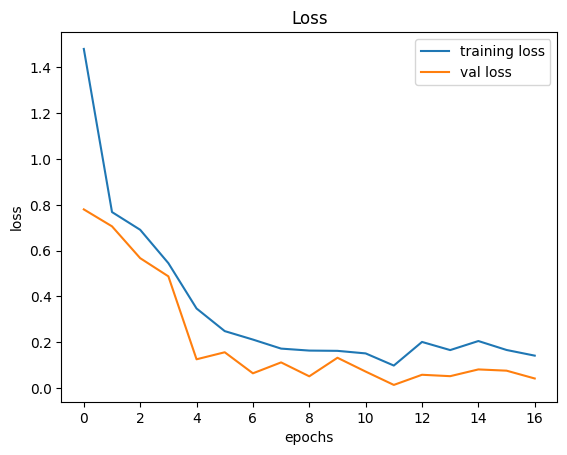

In [19]:
# Accuracy plot
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
# Save the model
model.save("./training/Traffic_Light_Detector_with_augmentation_and_callbacks.h5")

In [21]:
# Calculate the confusion matrix
# Load the saved model if needed
# model = load_model("./training/Traffic_Light_Detector_with_augmentation_and_callbacks.h5")

# Make predictions on test data
y_pred = model.predict(X_test)

# Convert predicted and true labels back from one-hot encoding
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[305   0   1]
 [  1 295   1]
 [  1   0 296]]
